# ch04.04 Style Transfer

* 날짜: 2022-08-17
* 이름: 고민수

## 학습내용
    - Style transfer에 대해 이해하고 코드로 구현한다.
    - Stlye transfer를 사용하여 이미지의 스타일을 바꾼다.

* [논문: Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)
* [Keras 실습 참고 코드](https://keras.io/examples/generative/neural_style_transfer/)

<p align='center'>
<img  src ='https://www.popit.kr/wp-content/uploads/2018/04/gatys_style_transfer.jpg' width=700>
</p>

## 이미지 전처리
---

In [20]:
import tensorflow as tf
from tensorflow.keras import preprocessing, utils, applications
import numpy as np
import matplotlib.pyplot as plt

In [45]:
class ImgPreprocess():
    
    def __init__(self, combination_shape, base_model=applications.vgg19):
        self.combination_shape = combination_shape
        self.base_model = base_model
    
    # 이미지 경로 -> 전처리된 텐서 변환
    def path2tensor(self, img_path):
        img = preprocessing.image.load_img(img_path, target_size=self.combination_shape[:2])
        img = preprocessing.image.img_to_array(img)
        img = np.expand_dims(img,axis=0)
        img = self.base_model.preprocess_input(img)
        img = tf.convert_to_tensor(img)
        return img
        
    # (전처리 된) 텐서 -> (전처리 전) 텐서 이미지
    def tensor2img(self, tensor):
        x = tensor.numpy()
        x = x.reshape(self.combination_shape)
        # VGG 전처리 되돌리기
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
        x = x[:, :, ::-1]
        x = np.clip(x, 0, 255).astype("uint8")
        return x

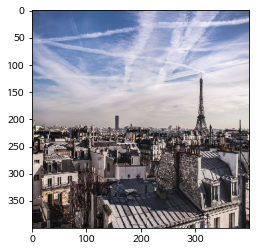

In [48]:
p = ImgPreprocess((400,400,3))
tensor = p.path2tensor("img_src/Content_img.jpg")
img = p.tensor2img(tensor)
plt.imshow(img)

![](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)

In [56]:
def display_imgs(target_img, ref_img, combination_img=None):
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.axis('off')
    plt.imshow(target_img)
    plt.title('Target Image (for content)', fontdict={"fontsize":20})
    plt.subplot(132)
    plt.axis('off')
    plt.imshow(ref_img)
    plt.title('Reference Img (for style)', fontdict={"fontsize":20})
    if combination_img is not None:
        plt.subplot(133)
        plt.axis('off')
        plt.imshow(combination_img)
        plt.title('Combination Image')
    plt.show()

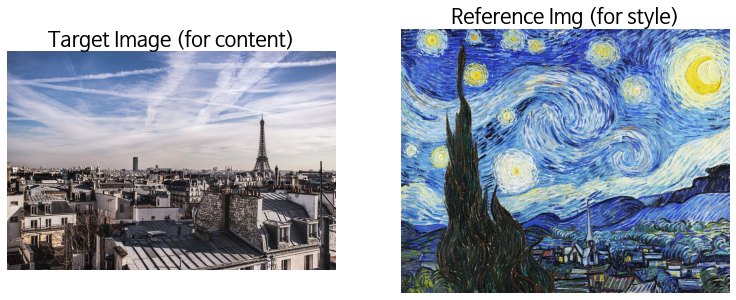

In [57]:
target_img = plt.imread("img_src/Content_img.jpg")
ref_img = plt.imread("img_src/Style_img.jpg")
display_imgs(target_img, ref_img)

## 모델 준비
---

<p align='center'>
<img  src ='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FzzZ6d%2FbtqtZOLsxg8%2Fdykdt2eKeWaxRFx8iyzEE0%2Fimg.png
' width=500>
</p>


In [60]:
import tensorflow as tf
from tensorflow.keras import preprocessing, utils, applications, models
import numpy as np

In [61]:
COMBINATION_SHAPE = (400, 600, 3)
BASE_MODEL = applications.vgg19

#### **특성 추출기**

In [59]:
model = BASE_MODEL.VGG19(include_top=False, weights="imagenet")
model.summary()

80134624/80134624 [==============================] - 11s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                             

In [68]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
extractor = models.Model(inputs=model.inputs, outputs=outputs_dict)

#### **이미지 텐서 준비**

In [70]:
p = ImgPreprocess(COMBINATION_SHAPE, BASE_MODEL)
# target (content)
target_tensor = p.path2tensor("img_src/Content_img.jpg")

# reference (style)
reference_tensor = p.path2tensor("img_src/Style_img.jpg")

# combination
combination_tensor = tf.Variable(p.path2tensor("img_src/Content_img.jpg"))

print(target_tensor.shape, reference_tensor.shape, combination_tensor.shape)

(1, 400, 600, 3) (1, 400, 600, 3) (1, 400, 600, 3)


#### **특성 추출**

## 손실 정의
---

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FboAUdP%2Fbtqt7RHqZqN%2Fx6SxUNLAdhpBw7J5JcK08k%2Fimg.png)

### **| 컨텐츠 손실**

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FclyRn2%2Fbtqt4yhBuoM%2FA6LcrtitH46HHzqYu40vo1%2Fimg.png)

#### **컨텐츠 손실 정의**

#### **컨텐츠 손실 계산**

### **| 스타일 손실**

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FE2teK%2FbtqubfnwDl2%2F9WdiAMbhEKKL9SNNfQqdlk%2Fimg.png)


#### **그램(gram) 매트릭스**

#### **스타일 손실 정의**

#### **스타일 손실 계산**

#### **| 총 변위 손실**

* 생성된 이미지가 공간적인 연속성을 가지도록 도와준다.
* 픽셀의 격자무늬가 과도하게 나타나는 것을 막아 준다.
* 일종의 규제 항으로 해석할 수 있다.

## 학습
---

### **| 학습을 위한 손실 함수 정리**